In [1]:
from orbit import Orbit, AU2km, mu, day2s
import elements as el
import angles as an
from util import load_dataset

import lambert_combine as lb
#from lambert_izzo import lambert as lambert_izzo
#from lambert import lambert as lambert_bate

import sys

import numpy as np
from numpy.linalg import norm
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import logging

# Load datasets
Created a small function to load asteroids directly into a set
earth is also created at MJD5400

In [2]:
asteroids, earth = load_dataset()
ISP = 3000*9.80665/1000 #km/s

In [3]:
type(asteroids), len(asteroids)

(set, 1436)

In [4]:
# defined a helper function get the specific asteroid im looking for

def select_asteroid(index):   
    """Helper function to get the asteroid as orbit object at given index"""
    #maybe just using lists is easier?
    #but this function can also be memoizeddddd
    if index == -1:
        return earth
    return [ast for ast in asteroids if ast.index==index][0]

In [5]:
select_asteroid(1057)

'2006QV89'

In [6]:
# >>> CREATED lambert_combine.py
# tool to use izzo and Bate lambert algorithm
#def lambert(*args):
#    try:
#        return lambert_izzo(*args)
#    except:
#        try:
#            return lambert_bate(*args)
#        except:
#            raise RunTimeError('Failed to solve Lamberts')

# Idea
define a node as a (`Orbit`, `asteroid index`) which describes the position and state vector fully. Then the children nodes are defined by the set of all possible new orbits to transition into. Cost_so_far is defined as total deltavs needed so far. While the velocity at a node does not match with the asteroid's velocity, we define it as a flyby or a specific asteroid. 

`node.len_of_chain()` returns the number of flybys it has found. Therefore the merit function is simply number of asteroids + mf/m0 and since mf/m0 will always be less than 1, this function is the explict form of the problem statement. 

In [7]:
# implemention of Dijkstra’s from https://www.redblobgames.com/pathfinding/a-star/implementation.html

import heapq

class PriorityQueue:
    def __init__(self):
        self.elements = []
    
    def empty(self):
        return len(self.elements) == 0
    
    def put(self, item, priority):
        heapq.heappush(self.elements, (priority, item))
    
    def get(self):
        return heapq.heappop(self.elements)[1]

In [51]:
class Node():
    """Node class defining sequences"""
    def __init__(self, epoch, index, approach_orbit=None, parent=None):
        
        
        self.epoch = epoch
        self.index = index
        self.asteroid = select_asteroid(index)
            
        self.approach_orbit = approach_orbit 
        #this is the orbit that defined at parents epoch and position,
        # and gets me to this asteroid's position at required epoch
        
        self.parent_node = parent
        
        if self.parent_node is None:
            self.visited_list = [self.index]
        else:
            self.visited_list = self.parent_node.visited_list + [self.index]

        
    def get_children(self):
        """Gets list of children nodes, which are the set of asteroids which may be potentially be visited next.
        1)
        The orbit that brought the spacecraft to the current asteroid & the permitted asteroids (not yet visited)
        are propagated for 100 days. 
        2)
        The relative distance (dr) between the spacecraft and the permitted asteroids (asteroids not yet visited)
        are computed. 
        3)
        At closest approach between the spacecraft and an asteroid, if dr is below a threshold distance (0.1AU), 
        this asteroid is a 'child' of the current node. 
        """
        permitted_asteroids = asteroid_ind.difference(set(self.visited_list)) # list of asteroids that are not visited yet
        
        # epoch list to propagate and search closest approach (min dr)
        epoch_lst = np.arange(self.epoch,self.epoch+100,10)
        
        # search for all permitted asteroids
        for astindx in permitted_asteroid:
            # create orbit object for asteroid
            ast_orbit = select_asteroid(astindx)
            
            # initialize relative distance list
            dr = [0,]*len(epoch_list)
            
            # iterate over allowable wait-time until next asteroid
            for i, epoch in enumerate(epoch_lst):
                # state-vector of spacecraft
                r_sc, v_sc = self.approach_orbit.rv(epoch)
                # state-vector of asteroid
                r_ast, v_ast = ast_orbit.rv(epoch)
                # relative distance between spacecraft and asteroid
                dr[i] = norm(r_ast - r_sc)
                
            # find epoch at which closest approach for the asteroid occurs 
            drmin, idx = min((drmin, idx) for (idx, drmin) in enumerate(dr))
            
            # check if closest approach is below threshold
            if drmin < 0.1*AU2km:
                # create child
                child = create_next_node(astindx,epoch[idx])
                
                # append to list of children
                children_list.append(child)
        
        return children_list #len(permitted_asteroids)
    
    
    def len_of_chain(self):
        
        if self.parent_node is None:
            return 0
        
        return 1 + self.parent_node.len_of_chain()
    
    
    def mass_at_node(self,m_in,dv,m0=1500,mprop=1000,Isp=3000):
        """Function to compute remaining spacecraft mass with Tsiolkovski
        Args:
            m_in (float): mass of spacecraft before burn
            dv (float): required delta V [km/s]
            m0 (float): total (initial) wet mass [kg]
            mprop (float): propellant mass [kg]
            Isp (float): specific impulse [s]
        Return:
            (float): spacecraft mass in [kg] at current node
        """
        ve = Isp*9.80665/1000 # exhaust velocity [km/s]
        m_f = m_in * np.exp(-dv/ve)
        
        # if remaining mass at node has to be less than empty mass of spacecraft
        if m_node < (m0-mprop):
            raise Out_of_fuel
        
        return m_f
    
    
    def create_next_node(self, target_ind, target_epoch):

        t0 = self.epoch
        r0, v0 = self.approach_orbit.rv()

        # find next ast and get its position (vel not needed)
        ast = select_asteroid(target_ind)
        r_target, v_target = ast.rv(target_epoch)

        # solve lamberts problem
        v1, v2 = lb.lambert(mu, r0, r_target, (target_epoch-t0)*day2s)

        # note that a maneouver is needed at the initial epoch to set us on a rendevousz path with target ast
        dv = v1 - v0 # only the initial change in velocity needed
        
        #incrememental cost (delta V, mass)
        if self.parent_node is None:
            # starting at earth
            inc_cost = max(0, norm(dv)-4.0) 
            # call mass_at_node to compute remaining mass after maneuver
            m_node = mass_at_node(1500,inc_cost)
        else:
            inc_cost = norm(dv)
            # call mass_at_node?
            

        # create new orbit, index=-2 since it is a transfer
        o_new = Orbit(name=f'Trx{self.len_of_chain()+1:2.0f}')
        o_new.from_rv(target_epoch, r_target, v2)    

        # create new node
        new_Node = Node(epoch = target_epoch, index = target_ind, approach_orbit=o_new, parent=self)

        # update cost and manouever history
        new_Node.maneuvers = self.maneuvers + [(t0, dv)]
        new_Node.cost = self.cost + inc_cost

        return new_Node
    
    
    def get_priority(self, dv=True, mf=False, count=False):
        
        # overall objective function is to maximise (number of asteroids + mf/m0)

        priority = 0
        
        if count: priority += self.len_of_chain()
        if mf   : priority += np.exp(-self.cost/ISP)
        if dv   : priority += -self.cost
        
        return -priority
        
        
    # printing tools
    def __repr__(self):
        
        return f'MJD {self.epoch:6.2f}, {self.asteroid.index:6.0f},    {self.asteroid},'
    
    def history(self):
        
        # call print(node.history()) to get the reverse sequence of nodes
        if self.parent_node is None:
            return 'Epoch,         Index,    Name,\n\n' + repr(self)
        
        return f'{self.parent_node.history()}\n{self}'
    
    def plot(self, only_traj=False):
        
        if self.parent_node is None:
            plt.plot(0,0,'xy')
            plt.grid()
            ax=plt.gca()
            ax.set_aspect(1)
            
            
        else:
            self.parent_node.plot(only_traj)
        
        if not only_traj:
            #plot orbit of current asteroid,
            self.asteroid.plot(start=self.epoch)
        
        (rx, ry, rz), v = self.asteroid.rv(self.epoch)
        plt.text(rx/AU2km,ry/AU2km, f'{self.len_of_chain()}')
        
        #plot current approach trajectory
        if self.parent_node is not None:
            self.approach_orbit.plot(start=self.parent_node.epoch, end=self.epoch)
        

SyntaxError: invalid syntax (<ipython-input-51-902bd70f9c1b>, line 119)

Define the starting point of the trajectory

In [47]:
launch_epoch = 58676.40
rv_earth = earth.rv(epoch = launch_epoch)
earth_initial = Orbit(name='Earth', index=-1) # index convention defined in orbit.py
earth_initial.from_rv(launch_epoch, *rv_earth)
earth_initial

Earth

In [10]:
earth_initial.epoch0

58676.4

In [43]:
earth_initial.rv(epoch=58767)  # solved with kepler's equation

(array([ 1.42695135e+08,  4.41616304e+07, -8.56875097e+02]),
 array([-9.29222730e+00,  2.83451663e+01, -4.25131856e-04]))

Create the initial node

In [11]:
#epoch, index, approach_orbit=None, parent=None
start_node = Node(launch_epoch, index=-1, approach_orbit=earth_initial, parent=None)
start_node.cost = 0.0
start_node.maneuvers = []

In [12]:
# we can query the standard stuff also about the root node
start_node.len_of_chain(), start_node.get_priority()

(0, -0.0)

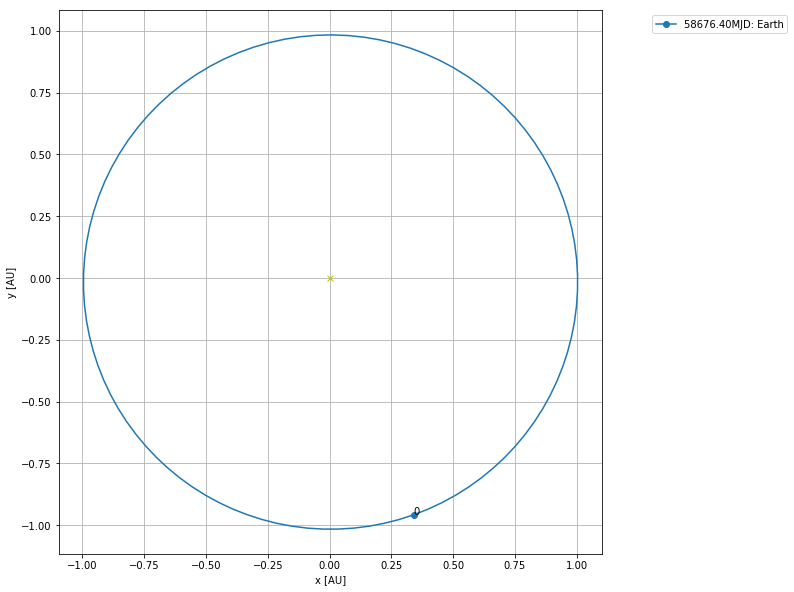

In [13]:
#PLOT!
fig = plt.figure(figsize=(10,10))
start_node.plot()
plt.legend()
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.35, 1))

# Define the first node
based on sequences found in russian paper

In [14]:
first_node = start_node.create_next_node(target_ind=1057, target_epoch=58731.65)

C:\Users\yurio\Documents\GitHub\reGTOC04\jupyternotebooks\lambert_combine.py:139: RuntimeWarning: invalid value encountered in power
  residue = np.power(_y_538(r1,r2,A,z)/_Stumpff_C(z), 3/2) * _Stumpff_S(z) + A*np.sqrt(_y_538(r1,r2,A,z)) - np.sqrt(mu)*tof
C:\Users\yurio\Documents\GitHub\reGTOC04\jupyternotebooks\lambert_combine.py:139: RuntimeWarning: invalid value encountered in sqrt
  residue = np.power(_y_538(r1,r2,A,z)/_Stumpff_C(z), 3/2) * _Stumpff_S(z) + A*np.sqrt(_y_538(r1,r2,A,z)) - np.sqrt(mu)*tof
C:\Users\yurio\Documents\GitHub\reGTOC04\jupyternotebooks\lambert_combine.py:144: RuntimeWarning: invalid value encountered in power
  Fdot = np.power(_y_538(r1,r2,A,z)/_Stumpff_C(z), 1.5) * (((1/(2*z)) * (_Stumpff_C(z) - 3*_Stumpff_S(z)/(2*_Stumpff_C(z)))) + 3*np.power(_Stumpff_S(z),2)/(4*_Stumpff_C(z))) + (A/8)*(3*_Stumpff_S(z)*np.sqrt(_y_538(r1,r2,A,z))/_Stumpff_C(z) + A*np.sqrt(_Stumpff_C(z)/_y_538(r1,r2,A,z)))
C:\Users\yurio\Documents\GitHub\reGTOC04\jupyternotebooks\lambert_co

In [15]:
# get cost and priority
first_node.cost, first_node.get_priority()

(0.0, -0.0)

In [16]:
print(first_node.history())

Epoch,         Index,    Name,

MJD 58676.40,     -1,    Earth,
MJD 58731.65,   1057,    '2006QV89',


In [17]:
first_node.len_of_chain()

1

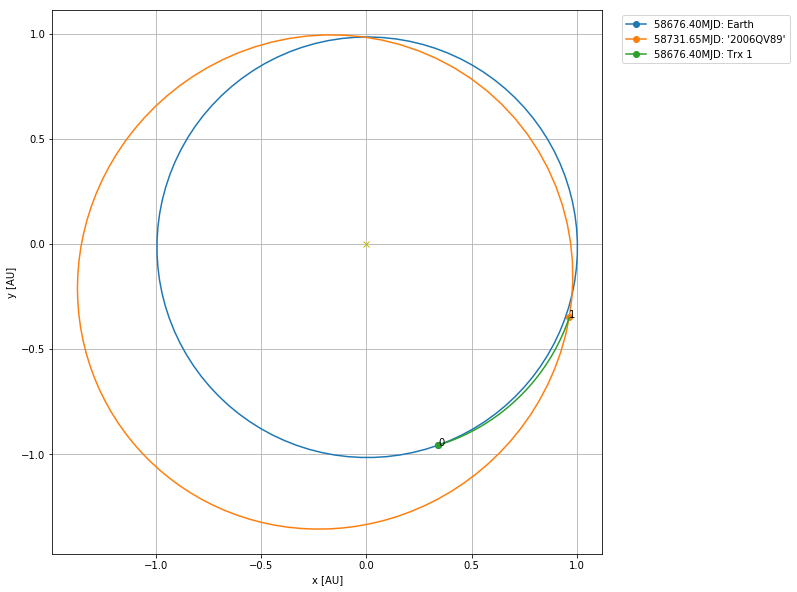

In [18]:
# PLOT
fig = plt.figure(figsize=(10,10))
first_node.plot() 
plt.legend()
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.35, 1))

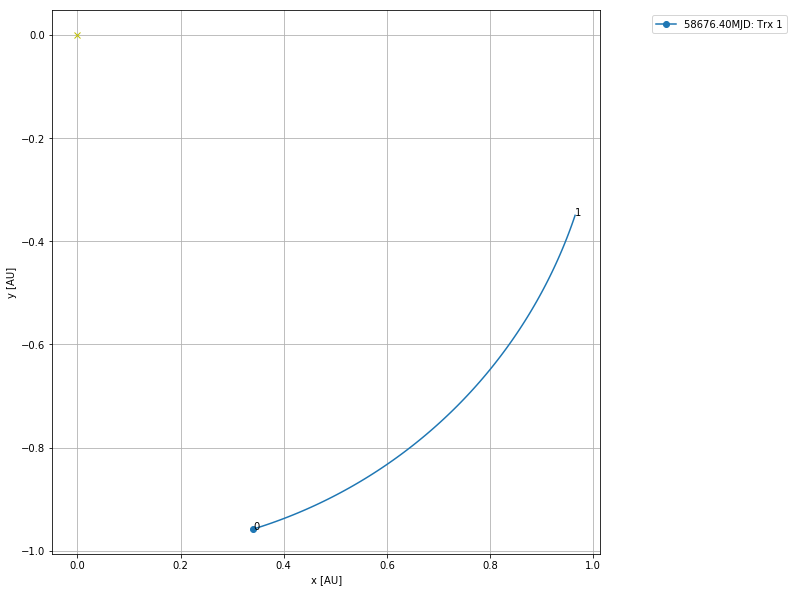

In [19]:
# PLOT
fig = plt.figure(figsize=(10,10))
first_node.plot(only_traj=True) 
plt.legend()
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.35, 1))

# second node

In [20]:
second_node = first_node.create_next_node(target_ind=1125, target_epoch=58801.45)

In [21]:
second_node.maneuvers

[(58676.4, array([-0.20509971, -1.43631196,  0.07282867])),
 (58731.65, array([-0.11494312,  0.08768156,  0.20003526]))]

In [22]:
second_node.cost, second_node.get_priority()

(0.24680777922685584, 0.24680777922685584)

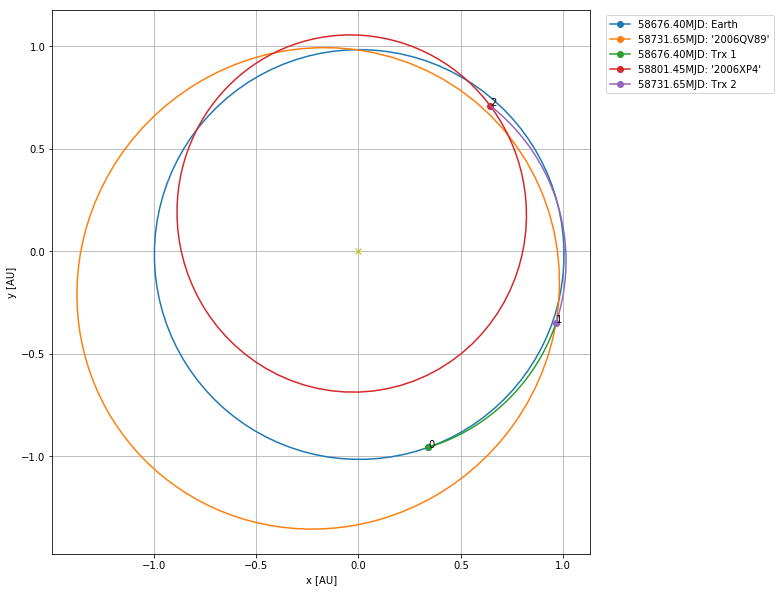

In [23]:
fig = plt.figure(figsize=(10,10))
second_node.plot() 
plt.legend()
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.35, 1))

# thrid node

In [24]:
third_node = second_node.create_next_node(target_ind=1328, target_epoch=58866.95)

In [25]:
print(third_node.history())

Epoch,         Index,    Name,

MJD 58676.40,     -1,    Earth,
MJD 58731.65,   1057,    '2006QV89',
MJD 58801.45,   1125,    '2006XP4',
MJD 58866.95,   1328,    '2008EP6',


In [26]:
third_node.maneuvers

[(58676.4, array([-0.20509971, -1.43631196,  0.07282867])),
 (58731.65, array([-0.11494312,  0.08768156,  0.20003526])),
 (58801.45, array([-0.32988735,  0.52634144,  0.14795608]))]

In [27]:
third_node.cost

0.8853623747672885

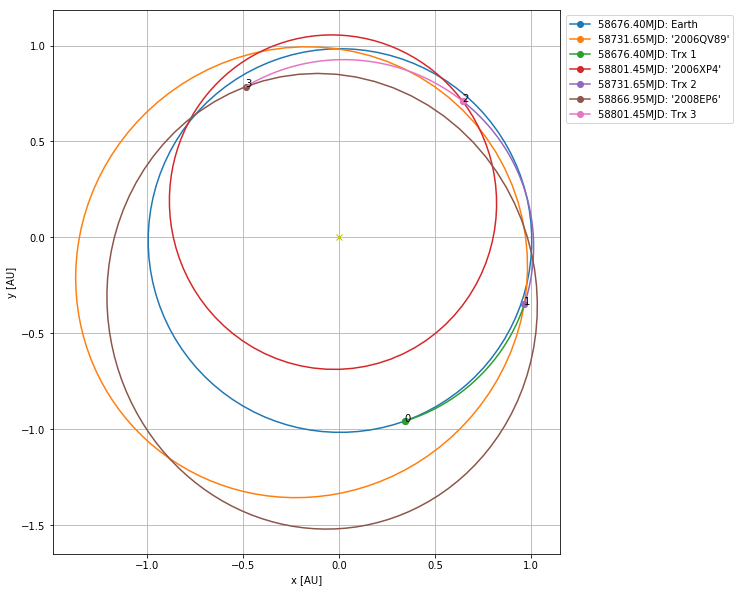

In [28]:
fig = plt.figure(figsize=(10,10))
third_node.plot() 
plt.legend()
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.35, 1))

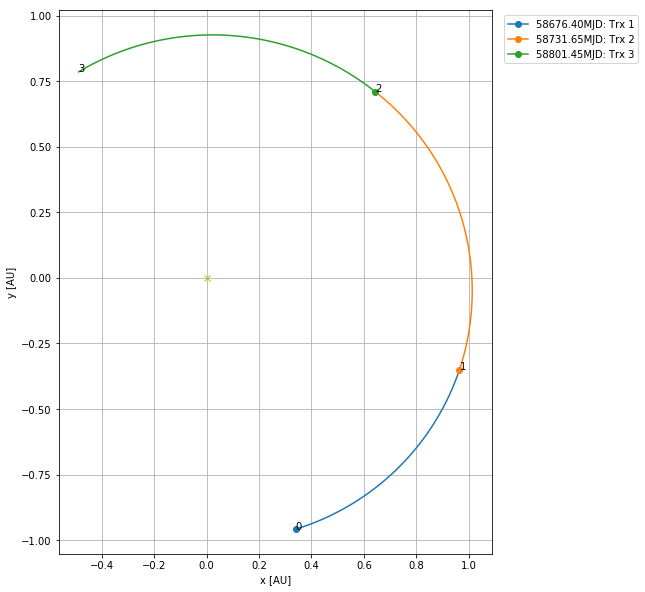

In [29]:
fig = plt.figure(figsize=(10,10))
third_node.plot(only_traj=True) 
plt.legend()
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.35, 1))

# Try to define a sequence
based on russian paper

In [30]:
t_list = [58731.65, 58801.45, 58866.95, 58973.95, 59084.55, 59119.45, 59221.75,59326.95, 59366.25,59419.55]
ind_list = [1057, 1125, 1328, 1181, 937,1077, 1289, 1000, 601, 1376]

In [31]:
nodes = [start_node]

In [32]:
for i, ind in enumerate(ind_list):
    new_node = nodes[-1].create_next_node(target_ind = ind, target_epoch=t_list[i])
    nodes.append(new_node)
    

In [33]:
nodes

[MJD 58676.40,     -1,    Earth,,
 MJD 58731.65,   1057,    '2006QV89',,
 MJD 58801.45,   1125,    '2006XP4',,
 MJD 58866.95,   1328,    '2008EP6',,
 MJD 58973.95,   1181,    '2007KV2',,
 MJD 59084.55,    937,    '2005XN27',,
 MJD 59119.45,   1077,    '2006TB7',,
 MJD 59221.75,   1289,    '2008AF4',,
 MJD 59326.95,   1000,    '2006HF6',,
 MJD 59366.25,    601,    '2003LW2',,
 MJD 59419.55,   1376,    '2008PK3',]

In [34]:
final_node = nodes[-1]

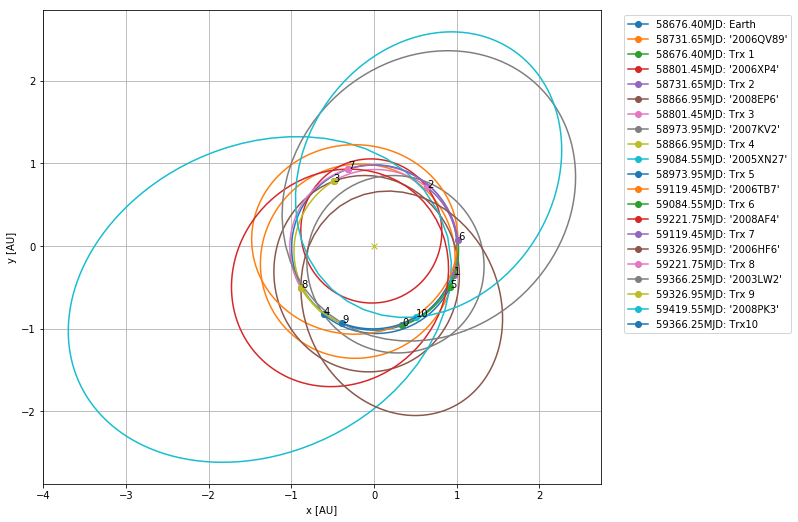

In [35]:
fig = plt.figure(figsize=(10,10))
final_node.plot()
plt.legend()
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.35, 1))


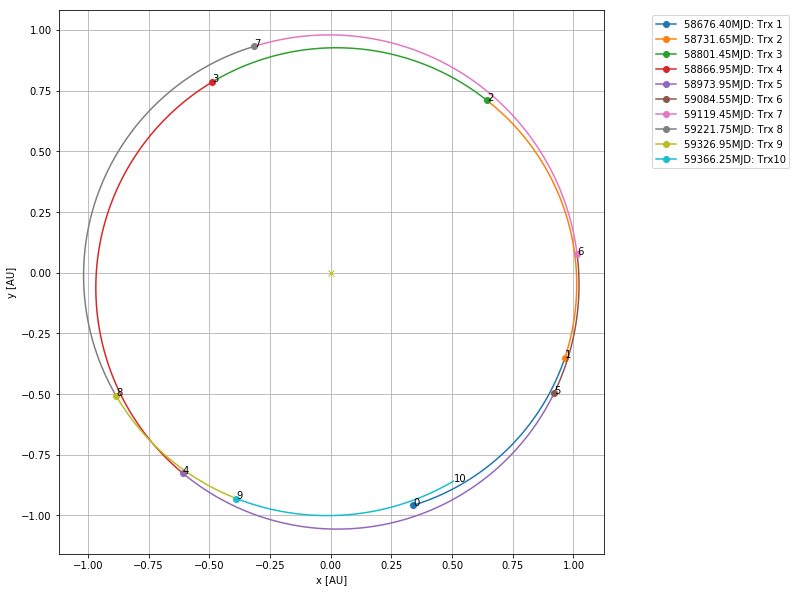

In [36]:
fig = plt.figure(figsize=(10,10))
final_node.plot(only_traj=True)
plt.legend()
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.35, 1))

In [37]:
final_node.maneuvers

[(58676.4, array([-0.20509971, -1.43631196,  0.07282867])),
 (58731.65, array([-0.11494312,  0.08768156,  0.20003526])),
 (58801.45, array([-0.32988735,  0.52634144,  0.14795608])),
 (58866.95, array([0.15972231, 0.02929418, 0.02763234])),
 (58973.95, array([ 0.04873194, -0.08043569,  0.26002869])),
 (59084.55, array([ 0.20222521,  0.30944667, -0.10444501])),
 (59119.45, array([-0.02882234,  0.15765074, -0.05001421])),
 (59221.75, array([0.5126921 , 0.58991377, 0.14833961])),
 (59326.95, array([ 0.12108697, -0.09079498, -0.04067516])),
 (59366.25, array([ 0.4458898 , -0.16419913,  0.43552919]))]

In [38]:
final_node.cost

3.4754249163792683

In [39]:
final_node.get_priority(dv=False, mf=True, count=False)

-0.8885791335530424

In [40]:
ISP

29.419949999999996

In [41]:
np.exp(-final_node.cost/ISP)

0.8885791335530424

In [42]:
final_node.maneuvers[0][1]

array([-0.20509971, -1.43631196,  0.07282867])

2.718281828459045